# 08 Forcasting Churn

In [1]:
import json
import sqlalchemy
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt

from pprint import pprint
from typing import Tuple, List, Dict

In [2]:
# Make a sql connection with sqlalchmey
conn_string = "postgresql://postgres-db/churn?user=postgres&password=password" 
engine = sqlalchemy.create_engine(
    conn_string, connect_args={'options': '-csearch_path={}'.format("socialnet7,public")}
)
conn = engine.connect()
# conn.close()

# Query with Pandas, e.g. list all tables
tables = pd.read_sql_query("SELECT * FROM information_schema.tables;", conn)
tables.head(3)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,churn,socialnet7,active_period,BASE TABLE,None,None,None,None,None,YES,NO,None
1,churn,socialnet7,event_type,BASE TABLE,None,None,None,None,None,YES,NO,None
2,churn,socialnet7,metric_name,BASE TABLE,None,None,None,None,None,YES,NO,None


In [3]:
import json 

with open("/app/fightchurn/listings/conf/socialnet7_listings.json", "r") as f: 
    conf = json.loads(f.read())
    # conf = Box(json.loads(f.read()))

chap9 = conf["chap9"]

In [4]:
pprint(chap9)

{'defaults': {'data_set_path': 'socialnet7/socialnet7_dataset2.csv',
              'type': 'py'},
 'list1': {'name': 'regression_auc', 'params': {}},
 'list2': {'name': 'top_decile_lift', 'params': {}},
 'list3': {'name': 'backtest', 'params': {'n_test_split': 2}},
 'list4': {'name': 'regression_cparam',
           'params': {'C_param': 0.02},
           'v1': {},
           'v2': {'C_param': 0.01},
           'v3': {'C_param': 0.005},
           'v4': {'C_param': 0.32,
                  'data_set_path': 'socialnet7/socialnet7_dataset3_dummies.csv'},
           'v5': {'C_param': 0.04,
                  'data_set_path': 'socialnet7/socialnet7_dataset3.csv'},
           'v6': {'C_param': 0.04}},
 'list5': {'name': 'crossvalidate',
           'params': {'n_test_split': 2},
           'v1': {'data_set_path': 'socialnet7/socialnet7_dataset.csv'},
           'v2': {'data_set_path': 'socialnet7/socialnet7_dataset3_dummies.csv'},
           'v3': {'data_set_path': 'socialnet7/socialnet7_datase

## Dependent Data & Functions

- Data are output of Chapter 8 notebook
- Functions are forked from Chapter 8 notebooks

In [73]:
import pickle

with open("/app/ch8-export.pickle", "rb") as handle:
    d = pickle.load(handle)
    
train_data = d["train_data"]
metric_groups = d["metric_groups"]
model = d["logreg_model"]
d.keys()

dict_keys(['raw_train_data', 'raw_test_data', 'train_data', 'metric_groups', 'test_data', 'logreg_model'])

In [7]:
# training data
train_data.head()

group_name,metric_group_0,metric_group_1,newfriend_pcnt_chng,unfriend_per_newfriend,days_since_newfriend,unfriend_per_month,post_per_message,newfriend_per_month,adview_per_post,like_per_post,dislike_per_month,dislike_pcnt,reply_per_message,is_churn
0,-0.549097,2.110926,-0.201102,-0.286460,-0.278495,-0.781045,-1.007845,-0.495320,-0.648489,0.529170,-0.177503,-0.443625,0.652640,False
1,0.168510,-1.119100,-0.201102,-0.286460,-0.278495,1.814266,1.937971,-0.268273,-0.881792,-0.876925,-0.177503,-0.335889,0.775205,False
2,-0.637119,1.577264,-0.201102,3.132593,-0.278495,-0.781045,-0.851206,-0.835891,-0.544171,-0.815355,-0.830230,-0.247713,0.605700,False
3,0.683287,2.265722,-0.698891,-0.286460,-0.278495,1.814266,-0.756789,-0.268273,0.936099,-1.270974,-2.135683,-1.076572,0.254015,False
4,0.176218,-1.119100,0.246908,-0.286460,-0.278495,-0.781045,0.697051,-0.041226,0.940821,1.312412,0.279693,-0.513573,0.775205,False


In [74]:
metric_groups.head()

,group_id,group_name,cluster_label,metrics,metric_counts
0,0,metric_group_0,cluster-1,"[like_per_month, post_per_month, adview_per_mo...",3
1,1,metric_group_1,cluster-8,"[message_per_month, reply_per_month]",2
2,2,newfriend_pcnt_chng,cluster-10,[newfriend_pcnt_chng],1
3,3,unfriend_per_newfriend,cluster-11,[unfriend_per_newfriend],1
4,4,days_since_newfriend,cluster-12,[days_since_newfriend],1


In [8]:
model

LogisticRegression(penalty='l1', solver='liblinear')

In [9]:
def prepare_data(grouped_data: pd.DataFrame, as_retention: bool = True) \
    -> Tuple[pd.DataFrame, pd.Series]:
    """Prepare data as X and y, with option to convert churn rate to retention rate"""
    
    X = grouped_data.drop(columns=['is_churn'])
    
    # as churn
    y = grouped_data['is_churn'].astype(int)
    
    # convert y values to retention, n.b. retention rate + churn rate = 1
    if as_retention: 
        # `is_churn = False` converted to `is_retained = True`
        y = np.subtract(1, y).rename("is_retained")
    
    return X, y
X, y = prepare_data(train_data, as_retention=True)
X.shape, y.shape, y.name

((24450, 13), (24450,), 'is_retained')

In [57]:
def sigmoid(x: npt.NDArray, rev: bool = False) -> npt.NDArray:
    """S (Sigmoid) curve with logistic, with optional reversed argument"""
    
    # regular shape of sigmoid function, from low to high
    probs =  1.0 / (1.0 + np.exp(-x))
    if rev: 
    # reversed shape of sigmoid, from high to low
        return 1 - probs
        
    return probs

In [59]:
def calculate_retention_impacts(model: LogisticRegression) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    logistict regression model is: logit(p) = β0 + β1x1 + β2x2 + ... + βnxn
    where 
        β0 is the bias (intercept) term 
        β1...βn are the weights (coefficients)
    
    N.B. the give scored group metrics (X) have been processed to have mean=0 and std=1
    
    OUTPUTS:
      metric_retain_impacts - marginal probability for a metric having 1 std higher than average
      average_retain_prob - probability of retention for an average observation (all metric have value = 0)
    """
    
    n_feat = model.n_features_in_
    coefs = model.coef_[0]
    intercept = model.intercept_
    
    # Average observation is when every metric equals to mean (0), i.e. x1...xn are all 0
    average_obs =  np.zeros((n_feat, ))
    average_retain_prob = sigmoid(np.dot(average_obs, coefs) + intercept)
    
    # Only one metric has value=1, others are 0
    # n.b. since std=1, it also means the observation is 1 std higher than average on that given metric
    only_one_metric_obs = pd.DataFrame(np.eye(n_feat)) # each column is a metric group, each row is a pseudo observation
    metric_retain_probs = []
    for idx, row in only_one_metric_obs.iterrows():
        metric_retain_probs.append(sigmoid(np.dot(row.values, coefs) + intercept))
    metric_retain_probs = np.array(metric_retain_probs)
    
    # For each metric, get its marginal impact on retention probabilty, as the difference to average
    # n.b. since data is 1 std higher than average, it's 1 std impact
    metric_retain_impacts = metric_retain_probs.ravel() - average_retain_prob
    
    return metric_retain_impacts, average_retain_prob

In [60]:
def save_regression_summary(model: LogisticRegression, cluster_groups: pd.DataFrame) -> pd.DataFrame:
    
    one_stdev_impact, average_retain = calculate_retention_impacts(model)
    
    model_summary = pd.DataFrame.from_dict({
        'group_metric_or_offset':  np.append(cluster_groups.index,'offset'), 
        'weight': np.append(model.coef_[0], model.intercept_), 
        'metric_retention_marginal_impact' : np.append(one_stdev_impact, average_retain), 
        'group_metrics' : np.append(cluster_groups.metrics, '(baseline)')
    })
    
    return model_summary

def save_dataset_predictions(model: LogisticRegression, X: pd.DataFrame) -> pd.DataFrame:
    
    preds = model.predict_proba(X)
    predictions = pd.DataFrame(
        preds, index=X.index, columns=['churn_prob','retain_prob']
        # preds has two columns, class=0 and class=1
    )
    
    return predictions

In [40]:
def logistic_regression(grouped_data, cluster_groups, as_retention=True):
    
    # get X and y as training data
    # default to convert to is_retained
    X, y = prepare_data(grouped_data, as_retention=as_retention)
    
    # fit model with training data
    model = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
    model.fit(X, y)
    
    # export summary
    summary = save_regression_summary(model, cluster_groups)
    # export predictions
    preds = save_dataset_predictions(model, X)
    
    return (X, y), model, summary, preds

## Model Validations

### Listing 9.1 AUC

> Area Under Curve
- https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, confusion_matrix,  ConfusionMatrixDisplay
)

In [12]:
def regression_auc(data: pd.DataFrame, model: LogisticRegression) -> float:
    """Compute AUC score with given churn data"""

    X, y = prepare_data(data, as_retention=True)
    
    predictions = model.predict_proba(X)
    auc_score = roc_auc_score(y, predictions[:,1])
    
    return auc_score

regression_auc(train_data, model)

0.7790053627615189

In [13]:
X, y = prepare_data(train_data, as_retention=True)

y_preds_proba = model.predict_proba(X)
# first column is "not_retained", second column is "is_retained"
y_preds = model.predict(X)
cm = confusion_matrix(y, y_preds)
pprint(cm)

array([[   33,  1350],
       [   18, 23049]])


In [14]:
y.value_counts()
# 1 as retained, 0 as not retained (churned)

1    23067
0     1383
Name: is_retained, dtype: int64

In [15]:
pd.Series(y_preds, name="is_retained_predictions").value_counts()
# 0 as predicted not reatined, 1 as predicted as retained

1    24399
0       51
Name: is_retained_predictions, dtype: int64

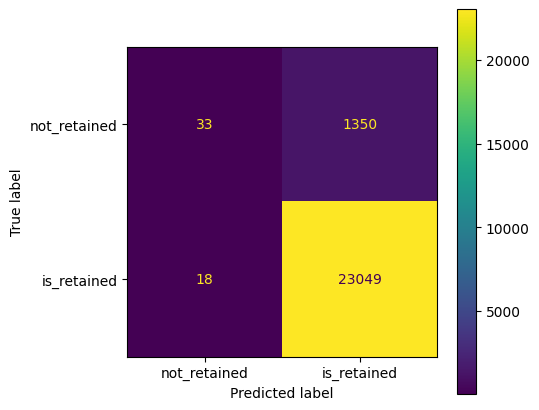

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(cm, display_labels=["not_retained", "is_retained"]).plot(ax=ax)
# ConfusionMatrixDisplay.from_predictions(y, y_preds).plot(ax=ax)
fig.show()

Notes 

- True Positive, i.e both True
  - predicted as "is_retained" and label is "is_retained" (23049)
- True Negative, i.e. both False
  - "not_retained" and "not_retained", (1350)
- False Positive, i.e. falsely classified as positive
  - predicted as "is_retained" but label is "not_retained"
- False Negative, i.e. falsely classified as negative
  - predicted as "not_retained" but label is "is_retained"
- True Positive Rate = True Positives / All Positives, also 'Sensitivity' or 'Recall'
- False Positive Rate = False Positives / All negatives, also 'Specificity'
- 

In [18]:
roc_auc_score(y, y_preds)

0.5115404179111551

In [19]:
roc_auc_score(y, y_preds_proba[:, 1])

0.7790053627615189

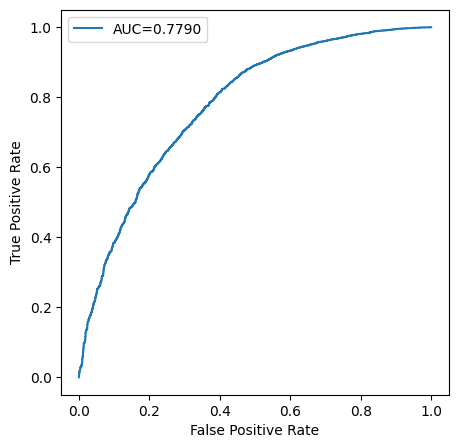

In [21]:
y_preds_proba = model.predict_proba(X)[::,1]
fpr, tpr, _ = roc_curve(y, y_preds_proba)
auc = roc_auc_score(y, y_preds_proba)

#create ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr,tpr, label=f"AUC={auc:.4f}")
plt.ylabel('True Positive Rate'); plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

### Listing 9.2 Top Decile Lift

- Lift
  - the relative increase in responses due to some treatment, relative to the baseline
  - e.g. lift = 2.0; when baseline is 1% and the increased value is 2%, (2% divided by 1%)
  - measures improvement over baseline
- Top Decile Lift
  - the ratio of churn rate in the top decile predicted to most at risk, to the overall churn rate
  - (Top decile churn rate, i.e. top 10% churn rate) divided by (Overall churn rate)
  - If in the top 10%, 2 are predicted as churn out of 5, i.e. 40% churn rate
    - Overall churn rate is 10%
    - Then Top Decile Lift is 40% / 10% = 4.0
  - Overall churn rate as baseline, because that is the churn rate if randomly guessing
  


In [22]:
def calculat_top_decile_lift(y_true: npt.NDArray, y_pred_proba: npt.NDArray) -> float:
    
    if np.unique(y_pred_proba).size < 10:
        return 1.0
    
    # overall churn rate
    overall_churn = y_true.sum() / y_true.shape[0]
    
    # top decile churn rate (top 10% at risk)
    ## sort by risk/probability to churn
    sort_by_risk = sorted(zip(y_pred_proba, y_true), key=lambda v: v[0], reverse=True)
    ## get top 10 count & index
    top10_count = round(y_true.shape[0] * .1)
    top10_churned_count = sum([v[1] for v in sort_by_risk[:top10_count]])
    ## top 10% churn rate
    top_decile_churn = top10_churned_count / top10_count
    
    # top decile lift
    lift = top_decile_churn / overall_churn
    
    return lift

In [22]:
def top_decile_lift(data: pd.DataFrame, model: LogisticRegression) -> float:

    X, y = prepare_data(data, as_retention=True)
    
    # first column is "not_retained", second column is "is_retained"
    # or, first is probabilty to become churned
    # or, first is risk to become churned
    predictions = model.predict_proba(X)
    
    # actual label on churn, 1 means the observation has churned
    # since the model is trained on as_retention=True, we need churn labels for lift
    y_churned = (1 - y).rename("is_churned")
    
    # top decile lift is about the top 10% most at-risk, so only on "not_churned"
    lift = calculat_top_decile_lift(y_churned, predictions[:, 0])
    
    return lift

top_decile_lift(train_data, model)

4.389009399855387

### Listing 9.3 Backtesting

> i.e. Time Series Split

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
  - Exhaustive search over specified parameter values for an estimator.
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
  - Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. 
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
  - Make a scorer from a performance metric or loss function.

In [28]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer

In [29]:
pprint(chap9["list3"])

{'name': 'backtest', 'params': {'n_test_split': 2}}


In [117]:
def backtest(data: pd.DataFrame, n_test_split: int) -> pd.DataFrame:

    X, y = prepare_data(data, as_retention=False)

    tscv = TimeSeriesSplit(n_splits=n_test_split)

    lift_scorer = make_scorer(calculat_top_decile_lift, needs_proba=True)
    score_models = {'lift': lift_scorer, 'AUC': 'roc_auc'}

    # Perform grid search
    retain_reg = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
    gsearch = GridSearchCV(
        estimator=retain_reg, 
        param_grid={'C': [1]}, 
        scoring=score_models, 
        cv=tscv, 
        verbose=1, 
        return_train_score=False,  
        refit='AUC'
    )
    gsearch.fit(X,y)
    
    result_df = pd.DataFrame(gsearch.cv_results_)

    # save_path = data_set_path.replace('.csv', '_backtest.csv')
    # result_df.to_csv(save_path, index=False)
    # print('Saved test scores to ' + save_path)
    return result_df

In [31]:
%%time
result =  backtest(train_data, chap9["list3"]["params"]["n_test_split"])

Fitting 2 folds for each of 1 candidates, totalling 2 fits
CPU times: user 648 ms, sys: 1.18 s, total: 1.83 s
Wall time: 495 ms


In [34]:
result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_lift,split1_test_lift,mean_test_lift,std_test_lift,rank_test_lift,split0_test_AUC,split1_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
0,0.153767,0.085924,0.018172,0.000957,1,{'C': 1},4.175589,4.090909,4.133249,0.04234,1,0.765167,0.771695,0.768431,0.003264,1


In [38]:
X, y = prepare_data(train_data, as_retention=False)

# time series cross validator
tscv = TimeSeriesSplit(n_splits=2, test_size=None)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None)

In [40]:
X.shape

(24450, 13)

In [50]:
for i, (train_index, test_index) in enumerate(tscv.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
# so first fold is using 0 to 8149 as train and 8150 to 16299 as test
# second fold is using 0 to 16299 as train, and rest as test

Fold 0:
  Train: index=[   0    1    2 ... 8147 8148 8149]
  Test:  index=[ 8150  8151  8152 ... 16297 16298 16299]
Fold 1:
  Train: index=[    0     1     2 ... 16297 16298 16299]
  Test:  index=[16300 16301 16302 ... 24447 24448 24449]


In [51]:
# wraps scoring functions for use in GridSearchCV and cross_val_score
lift_scorer = make_scorer(calculat_top_decile_lift, needs_proba=True)
lift_scorer

make_scorer(calculat_top_decile_lift, needs_proba=True)

In [52]:
score_models = {'lift': lift_scorer, 'AUC': 'roc_auc'}

# Perform grid search
retain_reg = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
gsearch = GridSearchCV(
    estimator=retain_reg,
    param_grid={'C': [1]}, 
    scoring=score_models, # score with both lift and AUC 
    cv=tscv,  # timeseries cross validator, i.e .backtesting
    verbose=1, 
    return_train_score=False,
    refit='AUC' # refit a final model on all the data
)
gsearch.fit(X, y)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [1]}, refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'lift': make_scorer(calculat_top_decile_lift, needs_proba=True)},
             verbose=1)

In [53]:
pd.DataFrame(gsearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_lift,split1_test_lift,mean_test_lift,std_test_lift,rank_test_lift,split0_test_AUC,split1_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
0,0.526288,0.047747,0.026082,0.000309,1,{'C': 1},4.175589,4.090909,4.133249,0.04234,1,0.765174,0.771699,0.768436,0.003263,1


### Listing 9.4 Cost parameter

In [55]:
pprint(chap9["list4"])

{'name': 'regression_cparam',
 'params': {'C_param': 0.02},
 'v1': {},
 'v2': {'C_param': 0.01},
 'v3': {'C_param': 0.005},
 'v4': {'C_param': 0.32,
        'data_set_path': 'socialnet7/socialnet7_dataset3_dummies.csv'},
 'v5': {'C_param': 0.04, 'data_set_path': 'socialnet7/socialnet7_dataset3.csv'},
 'v6': {'C_param': 0.04}}


In [61]:
def logistic_regression_params(grouped_data, cluster_groups, C_param, as_retention=True):
    
    # get X and y as training data
    # default to convert to is_retained
    X, y = prepare_data(grouped_data, as_retention=as_retention)
    
    # fit model with training data
    model = LogisticRegression(C=C_param, penalty='l1', solver='liblinear', fit_intercept=True)
    model.fit(X, y)
    
    # export summary
    summary = save_regression_summary(model, cluster_groups)
    # export predictions
    preds = save_dataset_predictions(model, X)
    
    return (X, y), model, summary, preds

In [102]:
params = [
    chap9["list4"]["params"]["C_param"], 
    *[chap9["list4"][f"v{i}"]["C_param"] for i in range(2, 7)]
]
sorted(params)

[0.005, 0.01, 0.02, 0.04, 0.04, 0.32]

In [103]:
summaries = {}
for param in sorted(params): 
    _, model, summary, preds = logistic_regression_params(train_data, metric_groups, param)
    summaries[f"C={param}"] = summary[["group_metric_or_offset", "weight"]].rename(columns={"weight": f"weight-C={param}"})
    
summaries.keys()

dict_keys(['C=0.005', 'C=0.01', 'C=0.02', 'C=0.04', 'C=0.32'])

In [114]:
result = (
    pd.concat(summaries.values(), axis=1).loc[:, lambda d: ~d.columns.duplicated()]
    # .style.format(precision=0)
)
# result.loc[:, ~result.columns.duplicated()]
# TODO: use .style.format to set 0 value as red
result

,group_metric_or_offset,weight-C=0.005,weight-C=0.01,weight-C=0.02,weight-C=0.04,weight-C=0.32
0,0,0.255575,0.303578,0.319166,0.325950,0.330850
1,1,0.392962,0.509696,0.582689,0.625659,0.670454
2,2,0.000000,0.047079,0.081403,0.100195,0.117475
3,3,-0.252136,-0.280579,-0.292228,-0.297666,-0.302395
4,4,0.013014,0.088569,0.138635,0.168415,0.197993
5,5,0.000000,-0.041429,-0.082102,-0.103406,-0.122847
6,6,0.000000,0.000000,0.000000,0.000000,0.000000
7,7,0.000000,0.047469,0.122899,0.172640,0.224804
8,8,-0.178617,-0.289205,-0.372924,-0.418063,-0.459983
9,9,0.000000,0.054827,0.131641,0.173335,0.212000


### Listing 9.5 Cross Validation

In [115]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression

# from fightchurn.listings.chap8.listing_8_2_logistic_regression import prepare_data
# from fightchurn.listings.chap9.listing_9_2_top_decile_lift import calc_lift

In [116]:
pprint(chap9["list5"])

{'name': 'crossvalidate',
 'params': {'n_test_split': 2},
 'v1': {'data_set_path': 'socialnet7/socialnet7_dataset.csv'},
 'v2': {'data_set_path': 'socialnet7/socialnet7_dataset3_dummies.csv'},
 'v3': {'data_set_path': 'socialnet7/socialnet7_dataset3.csv'}}


In [130]:
def test_n_weights(X: pd.DataFrame, y: pd.Series, c_params: List[float]):
    """For each C param, run test to get number of non-zero coefficients """
    
    n_weights = []
    for c in c_params:
        lr = LogisticRegression(penalty='l1',C=c, solver='liblinear', fit_intercept=True)
        res = lr.fit(X, ~y) # inverse of "is_churn" y
        
        n_weights.append(res.coef_[0].astype(bool).sum(axis=0))

    return n_weights

In [131]:
def cross_validate(data: pd.DataFrame, n_test_split: int) -> pd.DataFrame:

    X, y = prepare_data(data, as_retention=False)

    tscv = TimeSeriesSplit(n_splits=n_test_split)

    lift_scorer = make_scorer(calculat_top_decile_lift, needs_proba=True)
    score_models = {'lift': lift_scorer, 'AUC': 'roc_auc'}
    test_params = {'C' : [0.64, 0.32, 0.16, 0.08, 0.04, 0.02, 0.01, 0.005, 0.0025]}

    # Perform grid search
    retain_reg = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
    gsearch = GridSearchCV(
        estimator=retain_reg, 
        param_grid=test_params, 
        scoring=score_models, 
        cv=tscv, 
        verbose=1, 
        return_train_score=False,  
        refit=False,
    )
    gsearch.fit(X,y)
    
    result_df = pd.DataFrame(gsearch.cv_results_)
    
    # Test on number of weights with non-zero coefficients
    result_df['n_weights'] = test_n_weights(X, y, test_params["C"])
    
    return result_df

In [133]:
%%time
result = cross_validate(train_data, chap9["list5"]["params"]["n_test_split"])

Fitting 2 folds for each of 9 candidates, totalling 18 fits
CPU times: user 5.26 s, sys: 9.09 s, total: 14.4 s
Wall time: 3.49 s


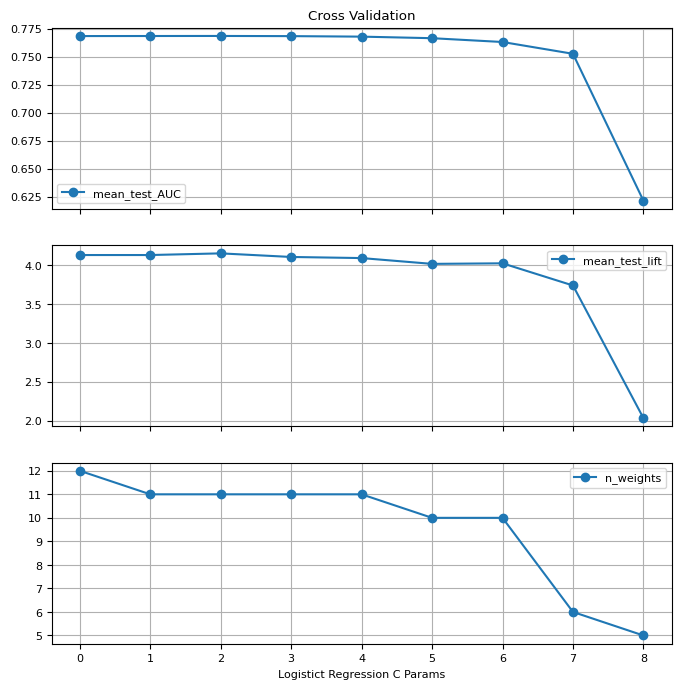

In [170]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 8))

ax1.plot(result["mean_test_AUC"], label="mean_test_AUC", marker="o")
ax1.set_title("Cross Validation")
ax1.grid(); ax1.legend()

ax2.plot(result["mean_test_lift"], label="mean_test_lift", marker="o")
ax2.grid(); ax2.legend()

ax3.plot(result["n_weights"], label="n_weights", marker="o")
ax3.grid(); ax3.legend()
ax3.set_xlabel("Logistict Regression C Params")

fig.show()

Notes

- With this implementation, best is at 6 C params, when no huge impact on AUC and Lift is observed with further reduction